# Cube in a Box

### Basic Functionality


In [1]:
import datacube # Load the datacube library


In [2]:
#Creating an instance of the datacube.
dc = datacube.Datacube(app='dc-visualize')

In [3]:
product='S2A_MSIL2A'.lower()
datasets = dc.find_datasets(product=product)
datasets[0]

Dataset <id=591c6c5e-0012-5ebf-a39a-5bc93594a0eb type=s2a_msil2a location=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2020/S2A_30NXM_20200211_0_L2A/>

In [4]:
%%time

# The defaults should find two datasets for spatial extent and time period
dataset = dc.load(
    product=product,
    id=datasets[0].id,
    output_crs="epsg:4326",
    resolution=[-0.01, 0.01]
)

CPU times: user 1.15 s, sys: 955 ms, total: 2.1 s
Wall time: 44.3 s


In [5]:
dataset

<xarray.Dataset>
Dimensions:          (latitude: 101, longitude: 100, time: 1)
Coordinates:
  * time             (time) datetime64[ns] 2020-02-11T10:39:22.031000
  * latitude         (latitude) float64 6.335 6.325 6.315 ... 5.355 5.345 5.335
  * longitude        (longitude) float64 -2.095 -2.085 -2.075 ... -1.115 -1.105
Data variables:
    coastal_aerosol  (time, latitude, longitude) uint16 0 0 0 ... 1366 1530 1512
    blue             (time, latitude, longitude) uint16 0 0 0 0 0 ... 0 0 0 0 0
    green            (time, latitude, longitude) uint16 0 0 0 0 0 ... 0 0 0 0 0
    red              (time, latitude, longitude) uint16 0 0 0 0 0 ... 0 0 0 0 0
    red_edge_1       (time, latitude, longitude) uint16 0 0 0 0 0 ... 0 0 0 0 0
    red_edge_2       (time, latitude, longitude) uint16 0 0 0 0 0 ... 0 0 0 0 0
    red_edge_3       (time, latitude, longitude) uint16 0 0 0 0 0 ... 0 0 0 0 0
    nir_1            (time, latitude, longitude) uint16 0 0 0 0 0 ... 0 0 0 0 0
    nir_2            

<IPython.core.display.Javascript object>


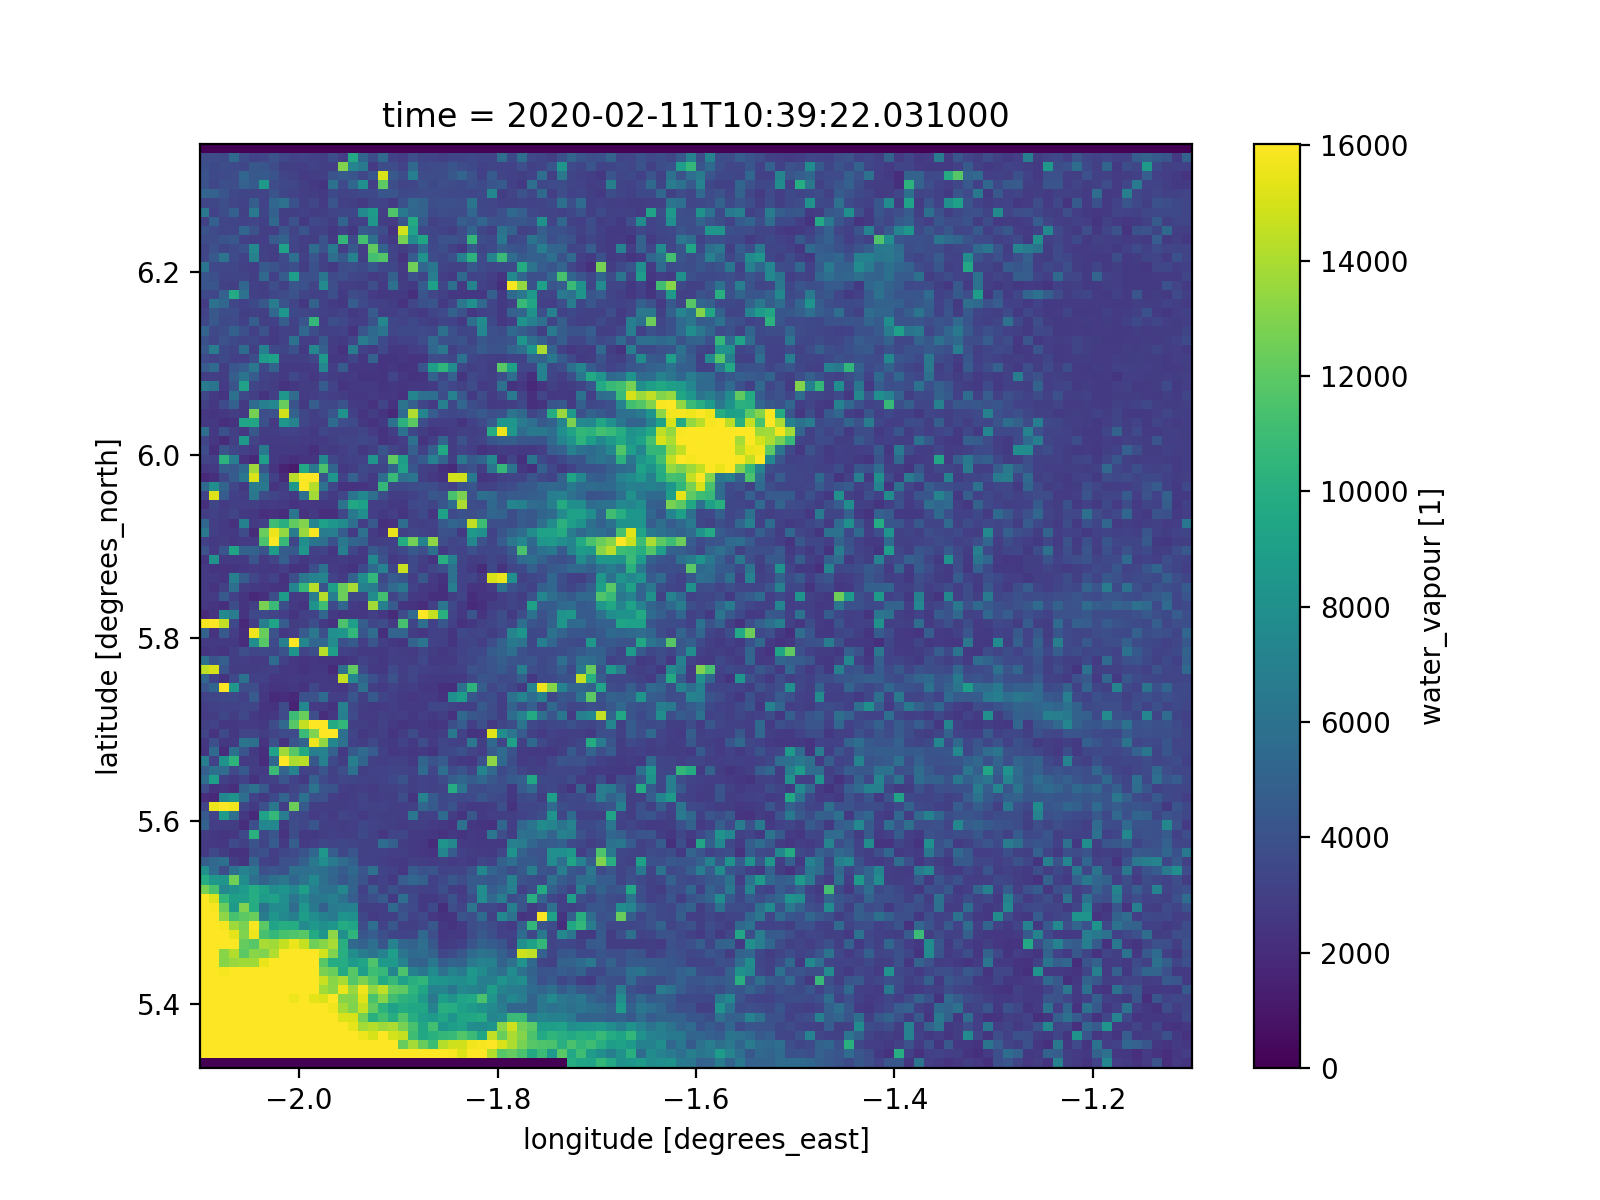

In [15]:
%matplotlib notebook

dataset.water_vapour.plot(size=6)

In [17]:
from datacube.storage import masking

masking.describe_variable_flags(dataset.SCL)

,bits,values,description
sca,"[0, 1, 2, 3, 4, 5, 6, 7]","{'1': 'saturated or defective', '2': 'dark are...",Sen2Cor Scene Classification


In [25]:
mask = masking.make_mask(dataset.SCL, sca='cloud high probability')

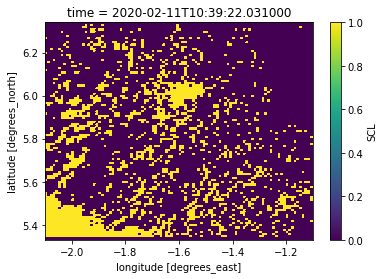

In [26]:
mask.plot()

*Please wait patiently for the above to finish (it's finished when the &ast; is gone).*

The `datacube.load()` command returns an [xarray](https://xarray.pydata.org/en/stable/). The key to building effective ODC algorithms is to master the use of the xarray. Please click on the documention to find out more otherwise a number of examples are provided below.

The xarray for landsat contains the dimensions of X, Y and Time - for each combination of these dimensions data listed as "Data Variables" can be retrieved. 

In [ ]:
print(dataset) # Viewing data

In [ ]:
# Querying the xarray using index 0 will retrieve the first record of each dimension
print(dataset.isel(time=[0], x=[0], y=[0])) 

In [ ]:
%matplotlib notebook

# Extract a cross-section of y measurements from the first timestep and the second row of x values.
cross_section = dataset.isel(time=0).sel(x=[1], method='nearest')

print(cross_section) 
cross_section.red.plot() # Plotting the measurements from the red band.

Next we'll explore [Landsat 8 quality band](https://landsat.usgs.gov/collectionqualityband), each pixel in the QA band contains unsigned integers that represent bit-packed combinations of surface, atmospheric, and sensor conditions that can affect the overall usefulness of a given pixel.

Used effectively, QA bits improve the integrity of science investigations by indicating which pixels might be affected by instrument artifacts or subject to cloud contamination. The ODC has in built methods that transform the metadata of a specific product to a libary of masking templates. For example, you are able to build a cloud mask directly from the ODC library.

In [ ]:
from datacube.storage import masking  # Import masking capabilities
print (masking.describe_variable_flags(dataset)) #D escribe the masks available

In [ ]:
# Create mask around all pixels deemed good according to parameters around cloud cover and saturation.
clean_pixel_mask = masking.make_mask(
    dataset.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion = False)

print(clean_pixel_mask)

masked_cloud = dataset.where(clean_pixel_mask)

print(masked_cloud)

Next we'll display the RGB bands that we have extracted from our cube for the first time slice (time = 0) in order to visualise a comprehendible RGB image we apply a histogram equalisation on each band before displaying. We'll also create visualisation of the pixels that are occluding land areas.

In [ ]:
%matplotlib notebook

def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)

time = 0
img_toshowNoMask = three_band_image(masked_cloud,bands = ['red', 'green', 'blue'], time = time)
img_toshow = three_band_image(dataset, bands = ['red', 'green', 'blue'], time = time)
fig = plt.figure(1, [10,20])
fig.canvas.mpl_connect('button_press_event', callback)

plt.subplot(211)
ax = plt.gca()
ax.set_title("All Pixels", fontweight = 'bold', fontsize = 16)
ax.set_xticklabels(dataset.x.values)
ax.set_yticklabels(dataset.y.values)
ax.set_xlabel('Easting', fontweight = 'bold')
ax.set_ylabel('Northing', fontweight = 'bold')

plt.imshow(img_toshow)

plt.subplot(212)
ax = plt.gca()
ax.set_title("Artifacts Filtered Out", fontweight = 'bold', fontsize = 16)
ax.set_xticklabels(dataset.x.values)
ax.set_yticklabels(dataset.y.values)
ax.set_xlabel('Easting', fontweight = 'bold')
ax.set_ylabel('Northing', fontweight = 'bold')
plt.imshow(img_toshowNoMask)

Next we'll select a single pixel from any of the above images and drill through the time dimension to calculate the change in nDVI.

Before running the below cell click on a location in the above visualisations to select an area to explore through time with a 100x100 lens.

In [ ]:
pixelDrillExtent = []
for i in [[x , y], [x + 100, y + 100]]:
    xI, yI = i
    getLong = dataset.isel(x=[xI], y=[yI]).isel(time=0).x.values
    getLat = dataset.isel(x=[xI], y=[yI]).isel(time=0).y.values
    
    pixelDrillExtent.append(transform_to_wgs(getLong, getLat,int(EPSG)))
print(pixelDrillExtent)

By expanding out the time extent and limiting the x,y extent in the datacube.load() we are able to retrieve cross section through time.


In [ ]:
%%time
# Load 6 months of data
drill_range = ('2019-01-01', '2019-07-01')
dataset_drill = dc.load(
    product='ls8_usgs_level1_scene',
    x=(pixelDrillExtent[0][0], pixelDrillExtent[1][0]),
    y=(pixelDrillExtent[0][1], pixelDrillExtent[1][1]), 
    output_crs='epsg:28355',
    resolution=(-30,30),
    time=drill_range,
    measurements=('red','nir','quality')
)

In [ ]:
print(dataset_drill)

We use band math to derive NDVI and mask out occluded measurements.

In [ ]:
%matplotlib notebook

red = dataset_drill.red.where(dataset_drill.red != dataset_drill.red.attrs['nodata'])
nir = dataset_drill.nir.where(dataset_drill.nir != dataset_drill.nir.attrs['nodata'])

cloud_free = masking.make_mask(
    dataset_drill.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion=False
)

ndvi = ((nir - red) / (nir + red)).where(cloud_free).dropna('time')
ndvi.isel(x=[3], y=[6]).plot() #Plots the change in nDVI over the time extent using the array index.
#ndvi.isel(x =465105, y=5194065).plot() #Plots the change in nDVI over the time extent using the X and Y coordinate.

Plot out a crossection accross the y axis of an x coordinate over a time extent.

In [ ]:
%matplotlib notebook
ndvi.isel(x=[0]).plot()